In [1]:
import sys
sys.path.append('../')

import tensorflow as tf

from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import lib.utils as utils
from lib.constants import S, B, C, INPUT_SIZE, CLASS_NAMES,CLASS_COLORS, LAMBDA_COORD, LAMBDA_NOOBJ
import os
import cv2
import math
import pickle

In [2]:
label_names = os.listdir('./../resources/labeled_data/labels')
print(label_names)

labels = []
for label_name in label_names:
    file = open(str('./../resources/labeled_data/labels/' + label_name), 'rb')
    label = pickle.load(file)
    file.close()
    labels.append(label)

['0.txt', '1.txt', '10.txt', '11.txt', '2.txt', '3.txt', '4.txt', '5.txt', '6.txt', '7.txt', '8.txt', '9.txt']


In [3]:
image_names = os.listdir('./../resources/labeled_data/images')
print(image_names)

images = []
for image_name in image_names:
    image = utils.loadImage(path='./../resources/labeled_data/images', name=image_name, resize=(INPUT_SIZE,INPUT_SIZE),color=False)
    images.append(image)

if len(images) != len(labels):
    sys.exit('#labels != #images')

['0.png', '1.png', '10.png', '11.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png']


In [4]:
#Pc  Bx  By  Bw  Bh     C1 C2
#0   0   0   0   0      0  0

In [5]:
#only works for B=1
def get_output_tensor(label):
    shape = (S,S,5*B+C)
    out = np.zeros(shape)

    cell_size = (int)(INPUT_SIZE/S)
    for box in label:
        x_cell = math.floor(box['b_x']/cell_size)
        y_cell = math.floor(box['b_y']/cell_size)

        if not np.array_equal(out[x_cell][y_cell], np.zeros(5*B+C)):
            sys.exit('More then one bounding box in cell')

        y = np.zeros(5*B+C)
        y[CLASS_NAMES.index(box['c'])-C] = 1

        y[0] = 1
        y[1] = (box['b_x'] - cell_size*x_cell) / cell_size
        y[2] = (box['b_y'] - cell_size*y_cell) / cell_size
        y[3] = box['b_w'] / cell_size
        y[4] = box['b_h'] / cell_size
        
        out[x_cell][y_cell] = y
    return out.flatten()

In [6]:
train_images = []
train_labels = []

for i in range(0, len(images)):
    train_images.append(images[i]/255)
    train_labels.append(get_output_tensor(labels[i]))

train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)

print(train_images.shape)
print(train_labels.shape)

(12, 448, 448)
(12, 490)


In [7]:
def leaky_reLu(x):
    return tf.keras.activations.relu(x, alpha=0.1)

In [8]:
model = models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(7, 7), activation=leaky_reLu, input_shape=(INPUT_SIZE, INPUT_SIZE, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation=leaky_reLu))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation=leaky_reLu))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation=leaky_reLu))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), activation=leaky_reLu))
model.add(layers.Flatten())

model.add(layers.Dense(5*S*S*(5*B+C), activation=leaky_reLu))
model.add(layers.Dense(S*S*(5*B+C)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 442, 442, 64)      3200      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 221, 221, 64)     0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                        

In [9]:
def loss(y_true, y_pred):

  #print(y_true)
  #print(y_pred)
  
  y_true = tf.reshape(y_true, (-1, S, S, 5*B+C))
  y_pred = tf.reshape(y_pred, (-1, S, S, 5*B+C))

  #print(y_true)
  #print(y_pred)

  #loss = tf.square(y_true - y_pred)
  # ignore elements where BOTH y_true & y_pred < 0.1
  #mask = tf.cast(tf.logical_or(y_true < 0, 1 >= 0.1) ,tf.float32)
  #loss *= mask


  #exists_box = tf.reshape(y_true[...,0:1], (-1,S*S))

  exists_box = y_true[...,0:1]


  y_pred_obj = tf.multiply(y_pred, exists_box)

  y_pred_no_obj = tf.multiply(y_pred, tf.subtract(1, exists_box))
  y_pred_no_obj = tf.add(y_pred_no_obj, tf.multiply(tf.cast(tf.fill(((1, S, S, 5*B+C)),1), 'float32') ,exists_box))

  #box loss
  box_loss1 = tf.math.reduce_sum(tf.math.squared_difference(y_true[...,1:3], y_pred_obj[...,1:3]))
  box_loss2 = tf.math.reduce_sum(tf.math.squared_difference(tf.math.sqrt(tf.math.abs(y_true[...,3:5])), tf.math.sqrt(tf.math.abs(y_pred_obj[...,3:5]))))

  box_loss = tf.math.add(box_loss1, box_loss2)

  #object loss
  object_loss = tf.math.reduce_sum(tf.math.squared_difference(y_true[...,0:1], y_pred_obj[...,0:1]))

  #no object loss
  no_object_loss = tf.math.reduce_sum(tf.math.squared_difference(y_true[...,0:1], y_pred_no_obj[...,0:1]))

  #class loss
  class_loss = tf.math.reduce_sum(tf.math.squared_difference(y_true[...,5:10], y_pred_obj[...,5:10]))


  loss = tf.math.add_n([tf.math.multiply(LAMBDA_COORD, box_loss), tf.math.multiply(LAMBDA_NOOBJ, no_object_loss), object_loss, class_loss])

  return loss#tf.reduce_sum(loss)# / tf.reduce_sum(mask)

In [10]:
model.compile(optimizer='adam',
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=loss,
              run_eagerly=True,
              metrics=['accuracy'])

train_labels = tf.convert_to_tensor(train_labels)
#print(train_labels)

#x = model.predict(train_images)
#print(x)

#history = model.fit(train_images, train_labels, epochs=10, 
#                    validation_data=(test_images, test_labels))

In [19]:
history = model.fit(train_images, train_labels, batch_size=6, epochs=200)

Epoch 1/200
2/2 [==============================] - 3s 2s/step - loss: 51.6976 - accuracy: 0.0833
Epoch 2/200
2/2 [==============================] - 3s 2s/step - loss: 51.7943 - accuracy: 0.0833
Epoch 3/200
2/2 [==============================] - 3s 2s/step - loss: 51.8712 - accuracy: 0.0833
Epoch 4/200
2/2 [==============================] - 3s 1s/step - loss: 52.4453 - accuracy: 0.0833
Epoch 5/200
2/2 [==============================] - 3s 2s/step - loss: 51.8485 - accuracy: 0.0833
Epoch 6/200
2/2 [==============================] - 3s 2s/step - loss: 51.4390 - accuracy: 0.0833
Epoch 7/200
2/2 [==============================] - 3s 2s/step - loss: 52.2074 - accuracy: 0.0833
Epoch 8/200
2/2 [==============================] - 3s 1s/step - loss: 51.5786 - accuracy: 0.0833
Epoch 9/200
2/2 [==============================] - 3s 1s/step - loss: 51.4711 - accuracy: 0.0833
Epoch 10/200
2/2 [==============================] - 3s 1s/step - loss: 51.5937 - accuracy: 0.0833
Epoch 11/200
2/2 [===========

In [20]:
model.save('./../resources/saved_model/my_model')

INFO:tensorflow:Assets written to: ./../resources/saved_model/my_model\assets


1/1 - 1s - loss: 0.7603 - accuracy: 0.1667 - 967ms/epoch - 967ms/step


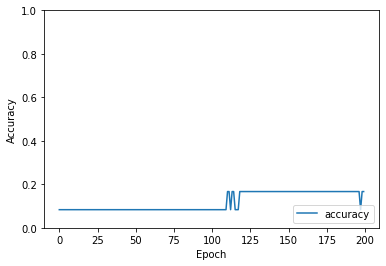

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
#plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
test_loss, test_acc = model.evaluate(train_images,  train_labels, verbose=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


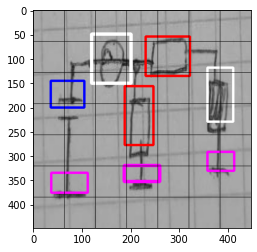

In [47]:
img = train_images[4].reshape(1, INPUT_SIZE, INPUT_SIZE, 1)


img = utils.loadImage('./../resources/test_images/', 'hand_test_2.png', resize=(INPUT_SIZE,INPUT_SIZE), color=False)
img = img/255
img = img.reshape(1, INPUT_SIZE, INPUT_SIZE, 1)

prediction = model.predict(img).reshape((S,S,(5*B)+C))

color_img = img[0].reshape(INPUT_SIZE,INPUT_SIZE)
color_img = np.float32(color_img)


color_img = cv2.cvtColor(color_img, cv2.COLOR_GRAY2BGR)

size = INPUT_SIZE / S

for i in range(0,7):
    for j in range(0,7):
        if prediction[i][j][0] > 0.5:
            color = CLASS_COLORS[np.argmax(prediction[i][j][-C:])]
            class_name = CLASS_NAMES[np.argmax(prediction[i][j][-C:])]

            center_x = (int)(prediction[i][j][1]*size + i*size)
            center_y = (int)(prediction[i][j][2]*size + j*size)
            width = prediction[i][j][3] * size
            height = prediction[i][j][4] * size
            #cv2.circle(color_img, ((int)(center_x),(int)(center_y)), 3,color,-1)
            #cv2.putText(color_img, class_name, (center_x, center_y), cv2.FONT_HERSHEY_SIMPLEX, 1, color, thickness=3)
            cv2.rectangle(color_img, ((int)(center_x-width/2), (int)(center_y-height/2)), ((int)(center_x+width/2), (int)(center_y+height/2)), color, thickness=(int)(5*prediction[i][j][0]))


for x in range(0, S):
    for y in range(0, INPUT_SIZE):
        color_img[y][x*(int)(INPUT_SIZE/S)] = (0,0,0)


for y in range(0, S):
    for x in range(0, INPUT_SIZE):
        color_img[y*(int)(INPUT_SIZE/S)][x] = (0,0,0)

plt.imshow(color_img, cmap='gray')

In [15]:
t1 = tf.constant([[[1,2,3,4,5,6],[1,2,3,4,5,6]],[[1,2,3,4,5,6],[1,2,3,4,5,6]]])

#print(t1)

#print(t3)
t_pred = tf.constant([1,1.5,0.5,0.7,0.7,1,1,0,0,0,  0,0,0,0,0,0,0,0,0,0, 1,0.3,0.4,0.8,0.8,1,0,1,0,0,   0,0,0,0,0,0,0,0,0,0, ])
t_pred = tf.reshape(t_pred, (2,2,10))

print(t_pred)
print(t_pred[...,0:1])

tf.Tensor(
[[[1.  1.5 0.5 0.7 0.7 1.  1.  0.  0.  0. ]
  [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]

 [[1.  0.3 0.4 0.8 0.8 1.  0.  1.  0.  0. ]
  [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]], shape=(2, 2, 10), dtype=float32)
tf.Tensor(
[[[1.]
  [0.]]

 [[1.]
  [0.]]], shape=(2, 2, 1), dtype=float32)


In [16]:
t1 = tf.constant([[[1,2,3,4,5,6],[1,2,3,4,5,6]],[[1,2,3,4,5,6],[1,2,3,4,5,6]]])
t3 = tf.constant([1,1,1,1])
t3 = tf.cast(t3, 'float32')
#print(t3)


t_true = tf.constant([1,0.5,0.5,0.7,0.7,0,1,0,0,0,  0,0,0,0,0,0,0,0,0,0, 1,0.3,0.4,0.8,0.8,1,0,0,0,0,   0,0,0,0,0,0,0,0,0,0, ])
#t_pred = tf.constant([1,1.5,0.5,0.7,0.7,1,1,0,0,0,  1,0,0,0,0,0,1,0,0,0, 1,0.3,0.4,0.8,0.8,1,0,0,0,0,   1,0,0,0,0,1,0,0,0,0, ])

t_pred = tf.constant([1,1.5,0.5,0.7,0.7,1,1,0,0,0,  0,0,0,0,0,0,0,0,0,0, 1,0.3,0.4,0.8,0.8,1,0,1,0,0,   0,0,0,0,0,0,0,0,0,0, ])



x = custom_loss(t_true, t_pred)

print(x)

t_true = tf.reshape(t_true, (2,2,10))
t_pred = tf.reshape(t_pred, (2,2,10))


exists_box = t_true[...,0:1]

#print(tf.reshape(exists_box, 4))
#
#print(t_pred)
#print(exists_box)
#
#test = tf.multiply(t_pred, exists_box)
#
#print(test)



#t_pred = tf.map_fn(lambda x: 2*x, t_pred)

#t_pred = tf.math.multiply(t_pred, tf.constant())

#print(t_true[...,1:3])
#
#t_l = tf.math.squared_difference(t_true, t_pred)
#
#print(t_l)
#
#t_l = tf.math.reduce_sum(t_l)

#print(t_true)
#
#print(t_pred)

#print(t_l)

NameError: name 'custom_loss' is not defined

In [ ]:
t_true = tf.constant([1,0.5,0.5,0.7,0.7,0,1,0,0,0,  0,0,0,0,0,0,0,0,0,0, 1,0.3,0.4,0.8,0.8,1,0,0,0,0,   0,0,0,0,0,0,0,0,0,0, ])
t_true = tf.reshape(t_true, (2,2,10))


help = tf.fill(t_true.shape, 0)
#print(help)
print(t_true)

print(tf.slice(t_true, [0,0,0], 4))

In [ ]:
## 3 3 5
#
#a = np.zeros((3,3,5))
#
#a[0][0][0] = 1
#a[0][0][1] = 1
#
#a[0][1][0] = 2
#a[0][1][1] = 2
#
#a[1][1][0] = 3
#a[1][1][1] = 3
#
#print(a)
#
#print(a.flatten())
#
#b = a.flatten()
#
#
#print(b.reshape((3,3,5)))

In [ ]:
image = utils.loadImage(path='./../resources/test_images', name='1.png', resize=(INPUT_SIZE, INPUT_SIZE), color=False)
image = np.asarray(image)

for x in range(0, S):
    for y in range(0, INPUT_SIZE):
        image[y][x*(int)(INPUT_SIZE/S)] = 0


for y in range(0, S):
    for x in range(0, INPUT_SIZE):
        image[y*(int)(INPUT_SIZE/S)][x] = 0


plt.imshow(image, cmap='gray')

print('Image Shape: {shape}'.format(shape=image.shape))

In [ ]:
#def convertImg(image, size=(32,32)):
#    image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
#    converted = np.zeros(shape=(size[0], size[1], 1))
#    for y in range(0, len(image)):
#        for x in range(0, len(image[y])):
#            converted[y][x][0] = image[y][x]
#
#    converted = converted/255
#    return converted

In [ ]:
# trainImages / Images
#ratio = 0.8
#train_data = []
#test_data = []
#
#class_names = os.listdir('./trainData')
#print(class_names)
#
#for class_name in class_names:
#    data = os.listdir('./trainData/{class_name}'.format(class_name=class_name))
#    for i in range(0, len(data)):
#        image = convertImg(utils.loadImage(path='./trainData/{class_name}'.format(class_name=class_name), name=data[i], resize=(32,32)))
#        if(i/len(data) < ratio):
#            train_data.append((image,class_names.index(class_name)))
#        else:
#            test_data.append((image,class_names.index(class_name)))
#
#random.shuffle(train_data)
#random.shuffle(test_data)
#
#train_images = []
#train_labels = []
#test_images = []
#test_labels = []
#
#for data in train_data:
#    train_images.append(data[0])
#    train_labels.append([data[1]])
#
#for data in test_data:
#    test_images.append(data[0])
#    test_labels.append([data[1]])
#
#train_images = np.asarray(train_images)
#train_labels = np.asarray(train_labels)
#test_images = np.asarray(test_images)
#test_labels = np.asarray(test_labels)

In [ ]:
#plt.figure(figsize=(10,10))
#for i in range(3):
#    plt.subplot(5,5,i+1)
#    plt.xticks([])
#    plt.yticks([])
#    plt.grid(False)
#    plt.imshow(train_images[i], cmap='gray')
#    # The CIFAR labels happen to be arrays, 
#    # which is why you need the extra index
#    plt.xlabel(class_names[train_labels[i][0]])
#plt.show()

In [ ]:
#model = models.Sequential()
#model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#
#model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(len(class_names)))
#
#model.summary()

In [ ]:
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])
#              
#
##history = model.fit(train_images, train_labels, epochs=10, 
##                    validation_data=(test_images, test_labels))
#
#history = model.fit(train_images, train_labels, epochs=30, 
#                    validation_data=(train_images, train_labels))
#

In [ ]:
#model.save('saved_model/my_model')
#model.save('../src/saved_model/my_model')

In [ ]:
#boxes = [[[100,100],[120,120]],[[140,100],[180,120]]]
#image = utils.loadImage("../src/testImages", "1.png")

def classify(boxes, image):
    
    model = tf.keras.models.load_model('saved_model/my_model')

    components = []
    for box in boxes:
        component = image[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        components.append(convertImg(component).reshape(-1,32,32,1))

    modelPredictions = model.predict(np.vstack(components))

    predictions = []

    for prediction in modelPredictions:
        predictions.append(class_names[np.argmax(prediction)])

    return predictions


In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
#new_model.summary()

img = convertImg(utils.loadImage(path='./', name='test.png', resize=(32,32)))

#img = train_images[3]


predictions_single = model.predict(img.reshape(-1,32,32,1))[0]
print(class_names)
print(predictions_single)
print(class_names[np.where(predictions_single == np.amax(predictions_single))[0][0]])

plt.imshow(img, cmap='gray')

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
test_loss, test_acc = model.evaluate(train_images,  train_labels, verbose=2)

print(test_acc)